**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")


100%|██████████| 67.4k/67.4k [00:00<00:00, 58.9MB/s]

Extracting files...


**Loading the Dataset**

In [ ]:
stroke_data_table = pd.read_csv(os.path.join(path, 'healthcare-dataset-stroke-data.csv'))  # Loading data to pandas format

# **Data and information visualization**

The beginning of the data: 

      id  gender   age  hypertension  heart_disease ever_married      work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
0   9046    Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
1  51676  Female  61.0             0              0          Yes  Self-employed          Rural             202.21   NaN     never smoked       1
2  31112    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
3  60182  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
4   1665  Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
Description of the data table: 


                 id          age  hypertension  heart_disease  avg_

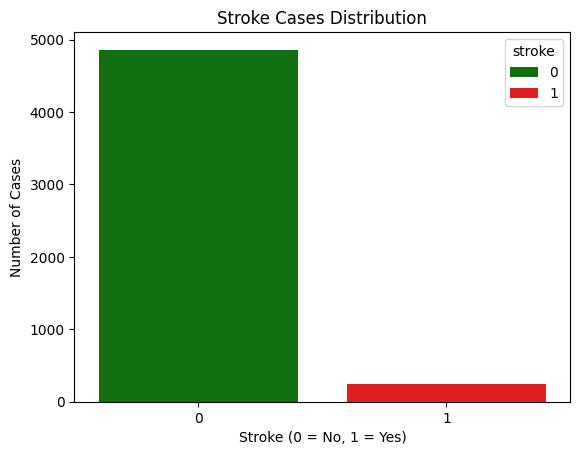

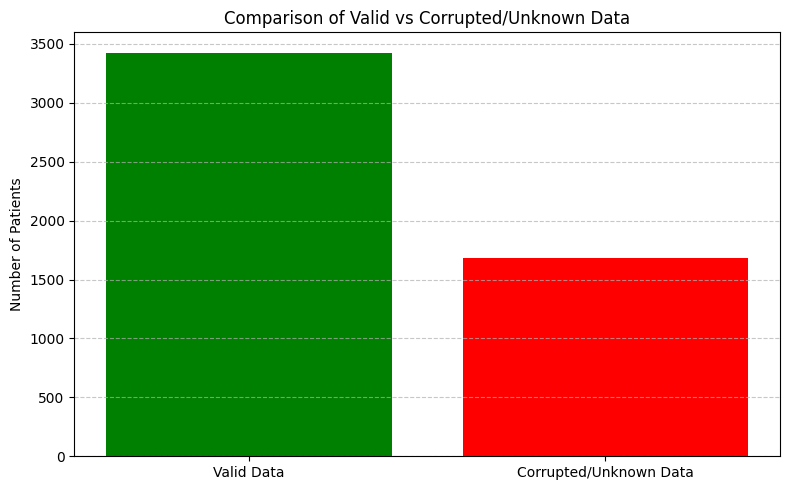

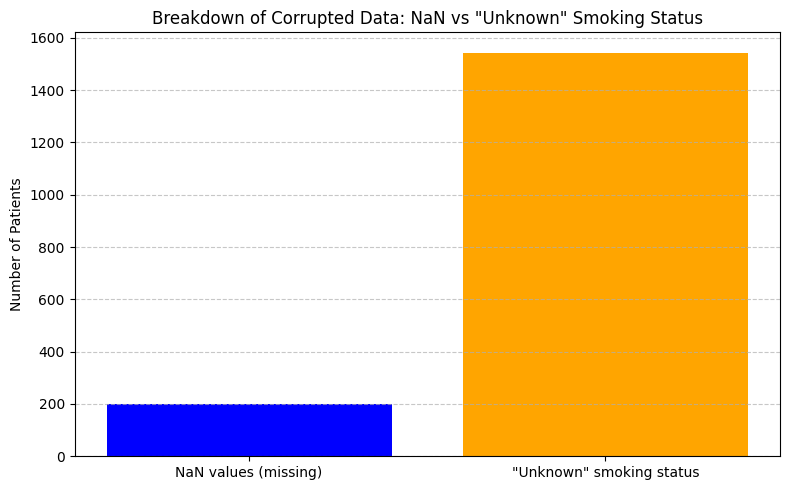


BMI Missing Data Analysis:

Number of rows with missing BMI: 201
Number of rows with BMI present: 4909


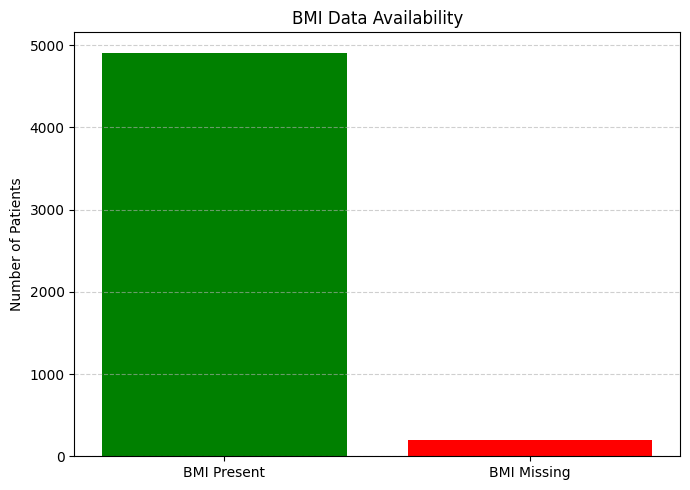




Stroke count across ages: 





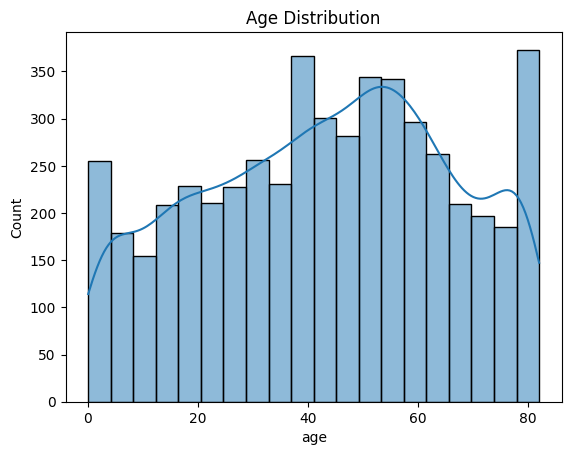

In [ ]:
# Fixing display lenghts for proper data showcasing
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("The beginning of the data: \n")
print(stroke_data_table.head()) # ShowCase the beginning of the data table

print("Description of the data table: \n\n")
print(stroke_data_table.describe())

# Count of stroke cases
stroke_counts = stroke_data_table['stroke'].value_counts()

print("\n\n\nStroke Case Summary (in data-set):\n")
print(f"Number of stroke-free cases (stroke = 0): {stroke_counts.get(0, 0)}")
print(f"Number of stroke cases (stroke = 1): {stroke_counts.get(1, 0)}")

# Visualize
# Define custom color palette: 0 → green, 1 → red
countplot_colors = {0: 'green', 1: 'red'}

# Plot
sns.countplot(data=stroke_data_table, x='stroke', hue='stroke', palette=countplot_colors)
plt.title("Stroke Cases Distribution")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Number of Cases")
plt.show()

# Identify corrupted data
is_missing = stroke_data_table.isnull().any(axis=1)
is_unknown_smoking = stroke_data_table['smoking_status'] == 'Unknown'
corrupted_rows = is_missing | is_unknown_smoking

# Count corrupted and valid rows
num_corrupted = corrupted_rows.sum()
num_valid = len(stroke_data_table) - num_corrupted

print() # added \n

# --- Plot 1: Valid vs Corrupted ---
labels1 = ['Valid Data', 'Corrupted/Unknown Data']
counts1 = [num_valid, num_corrupted]
colors1 = ['green', 'red']

plt.figure(figsize=(8, 5))
plt.bar(labels1, counts1, color=colors1)
plt.title('Comparison of Valid vs Corrupted/Unknown Data')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2: Breakdown of Corrupted Data (NaN vs Unknown) ---
print() # added \n
num_nan_rows = is_missing.sum()
num_unknown_smoking = is_unknown_smoking.sum()

labels2 = ['NaN values (missing)', '"Unknown" smoking status']
counts2 = [num_nan_rows, num_unknown_smoking]
colors2 = ['blue', 'orange']

plt.figure(figsize=(8, 5))
plt.bar(labels2, counts2, color=colors2)
plt.title('Breakdown of Corrupted Data: NaN vs "Unknown" Smoking Status')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nBMI Missing Data Analysis:\n")

# Check which rows have missing BMI
missing_bmi_mask = stroke_data_table['bmi'].isna()
num_missing_bmi = missing_bmi_mask.sum()
num_present_bmi = len(stroke_data_table) - num_missing_bmi

print(f"Number of rows with missing BMI: {num_missing_bmi}")
print(f"Number of rows with BMI present: {num_present_bmi}")

# Create labels and counts
labels = ['BMI Present', 'BMI Missing']
counts = [num_present_bmi, num_missing_bmi]
colors = ['green', 'red']

# Plot
plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color=colors)
plt.title('BMI Data Availability')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n\n\nStroke count across ages: \n\n\n")
sns.histplot(stroke_data_table['age'], kde=True)
plt.title("Age Distribution")
plt.show()


# **Preprocessing**

In [ ]:
# Load data
df = stroke_data_table.copy()

# Replace 'Unknown' with NaN in smoking_status
df['smoking_status'] = df['smoking_status'].replace('Unknown', pd.NA)

# Fill missing values in numeric columns
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Fill missing binary columns before mapping
df['ever_married'] = df['ever_married'].fillna(df['ever_married'].mode()[0])
df['Residence_type'] = df['Residence_type'].fillna(df['Residence_type'].mode()[0])

# Map binary columns
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# Fill unknowns in smoking_status and encode categoricals
df['smoking_status'] = df['smoking_status'].fillna('Unknown')
df = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)
print(df)
# Split features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Just in case: Fill remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_test.median(numeric_only=True))

# Align test set to training set's columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Store all processed data in a single dictionary
data_after_preprocessing = {
    'original_training_features': X_train,                # Original training features (before SMOTE)
    'original_test_features': X_test,                     # Test features
    'original_training_lables': y_train,                  # Original training labels (before SMOTE)
    'labels_test': y_test,                                # Test labels
    'modified_balanced_training_features': X_train_resampled,         # Balanced training features (after SMOTE)
    'modified_balanced_lables': y_train_resampled            # Balanced training labels (after SMOTE)
}


         id   age  hypertension  heart_disease  ever_married  Residence_type  avg_glucose_level   bmi  stroke  gender_Male  gender_Other  work_type_Never_worked  work_type_Private  work_type_Self-employed  work_type_children  smoking_status_formerly smoked  smoking_status_never smoked  smoking_status_smokes
0      9046  67.0             0              1             1               1             228.69  36.6       1         True         False                   False               True                    False               False                            True                        False                  False
1     51676  61.0             0              0             1               0             202.21  28.1       1        False         False                   False              False                     True               False                           False                         True                  False
2     31112  80.0             0              1             1             

# Data after preprocessing:

                                NaN Count  Unknown Count
id                                   1022              0
age                                  1022              0
hypertension                         1022              0
heart_disease                        1022              0
ever_married                         1022              0
Residence_type                       1022              0
avg_glucose_level                    1022              0
bmi                                  1022              0
gender_Male                          1022              0
gender_Other                         1022              0
work_type_Never_worked               1022              0
work_type_Private                    1022              0
work_type_Self-employed              1022              0
work_type_children                   1022              0
smoking_status_formerly smoked       1022              0
smoking_status_never smoked          1022              0
smoking_status_smokes          

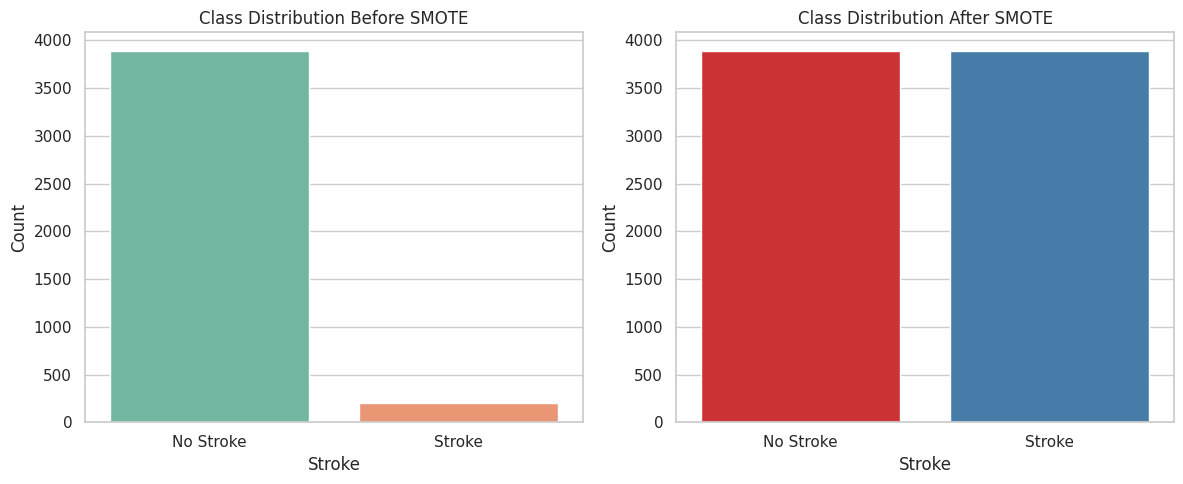

In [ ]:
# Combine all X/y DataFrames into one DataFrame for missing value analysis
combined_df = pd.concat([
    data_after_preprocessing['original_training_features'],
    data_after_preprocessing['original_test_features'],
    data_after_preprocessing['original_training_lables'],
    data_after_preprocessing['labels_test']
], axis=1)

# Count NaN values per column
null_counts = combined_df.isna().sum()

# Count 'Unknown' string values per column
unknown_counts = combined_df.apply(
    lambda col: (col == 'Unknown').sum() if col.dtypes == 'object' else 0
)

# Combine the two into a single DataFrame
missing_info = pd.DataFrame({
    'NaN Count': null_counts,
    'Unknown Count': unknown_counts
})

print(missing_info)

# Plot class distributions before and after SMOTE
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=data_after_preprocessing['original_training_lables'],
              hue=data_after_preprocessing['original_training_lables'],
              palette="Set2", ax=axes[0], legend=False)
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Stroke")
axes[0].set_ylabel("Count")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Stroke', 'Stroke'])

# After SMOTE
sns.countplot(x=data_after_preprocessing['modified_balanced_lables'],
              hue=data_after_preprocessing['modified_balanced_lables'],
              palette="Set1", ax=axes[1], legend=False)
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Stroke")
axes[1].set_ylabel("Count")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Stroke', 'Stroke'])

plt.tight_layout()
plt.show()

# **Training & Evaluation of Multiple Models**

--- Random Forest ---
Accuracy : 0.9119373776908023
Precision: 0.15517241379310345
Recall   : 0.18
F1 Score : 0.16666666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.16      0.18      0.17        50

    accuracy                           0.91      1022
   macro avg       0.56      0.56      0.56      1022
weighted avg       0.92      0.91      0.92      1022



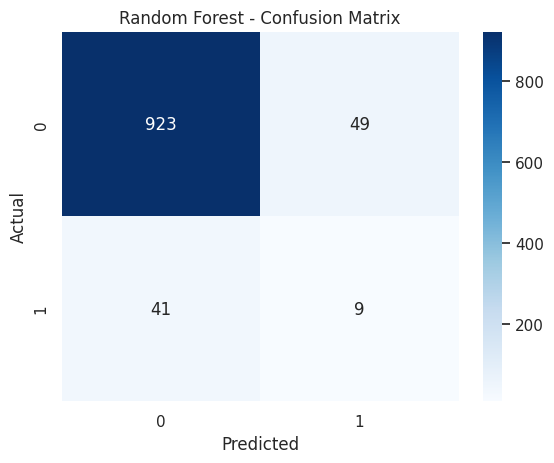

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:11:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost ---
Accuracy : 0.9119373776908023
Precision: 0.1
Recall   : 0.1
F1 Score : 0.1

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.10      0.10      0.10        50

    accuracy                           0.91      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.91      0.91      0.91      1022



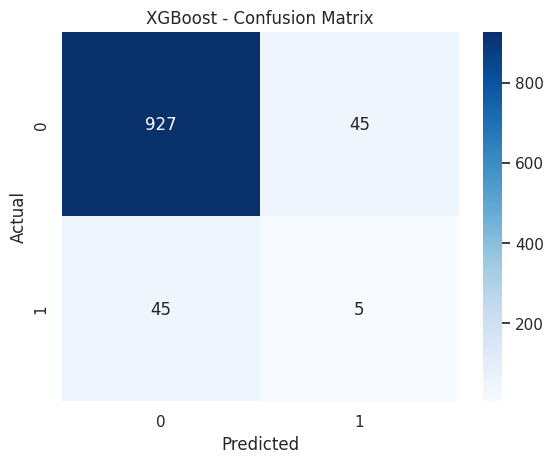

In [ ]:
# Define function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest")

# 2. XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost")

--- Random Forest (Threshold = 0.4) ---
Accuracy : 0.8747553816046967
Precision: 0.11764705882352941
Recall   : 0.24
F1 Score : 0.15789473684210525

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       972
           1       0.12      0.24      0.16        50

    accuracy                           0.87      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.87      0.89      1022



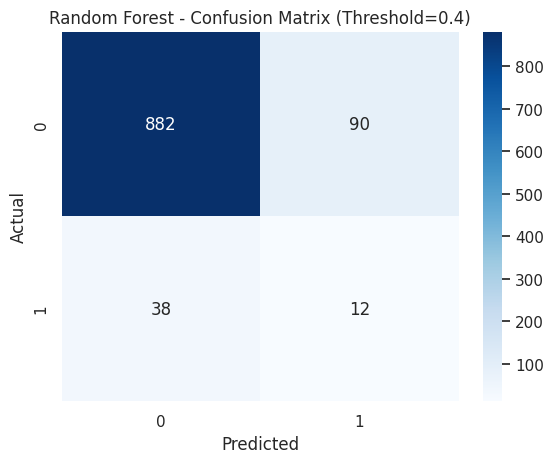

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:11:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Threshold = 0.4) ---
Accuracy : 0.9021526418786693
Precision: 0.109375
Recall   : 0.14
F1 Score : 0.12280701754385964

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.11      0.14      0.12        50

    accuracy                           0.90      1022
   macro avg       0.53      0.54      0.54      1022
weighted avg       0.91      0.90      0.91      1022



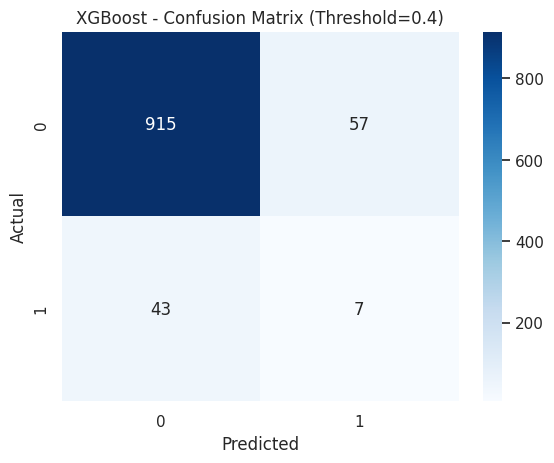

In [ ]:
def evaluate_model_with_threshold(model, X_test, y_test, model_name, threshold=0.6):
    # Get probabilities for class 1
    y_probs = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_probs >= threshold).astype(int)

    print(f"--- {model_name} (Threshold = {threshold}) ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Threshold={threshold})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model_with_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest", threshold=0.4)

# 2. XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model_with_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost", threshold=0.4)

Best Threshold = 0.26 (F1 = 0.21)

--- Random Forest (Threshold = 0.26) ---
Accuracy : 0.7876712328767124
Precision: 0.1288888888888889
Recall   : 0.58
F1 Score : 0.2109090909090909

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.58      0.21        50

    accuracy                           0.79      1022
   macro avg       0.55      0.69      0.54      1022
weighted avg       0.93      0.79      0.84      1022



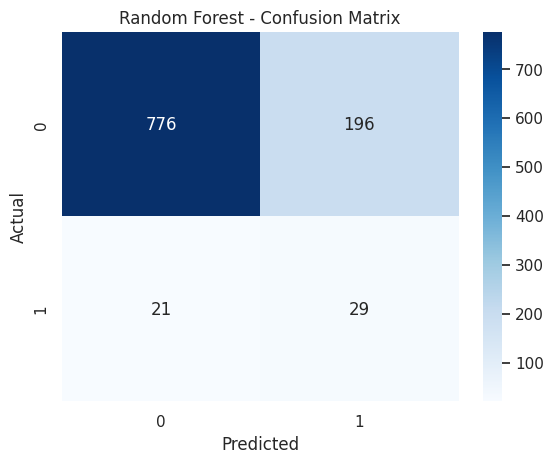

Best Threshold = 0.03 (F1 = 0.21)

--- XGBoost (Threshold = 0.030402524396777153) ---
Accuracy : 0.7534246575342466
Precision: 0.12313432835820895
Recall   : 0.66
F1 Score : 0.20754716981132076

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       972
           1       0.12      0.66      0.21        50

    accuracy                           0.75      1022
   macro avg       0.55      0.71      0.53      1022
weighted avg       0.94      0.75      0.82      1022



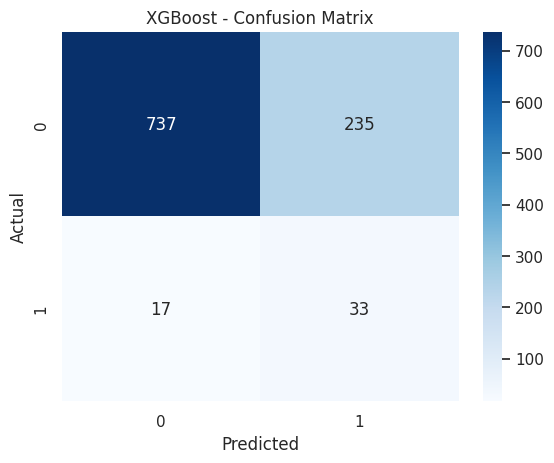

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    precision_recall_curve
)

# -----------------------
# Evaluation with Threshold
# -----------------------
def evaluate_model_with_threshold(model, X_test, y_test, model_name, threshold=0.5):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    print(f"\n--- {model_name} (Threshold = {threshold}) ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# -----------------------
# Find Best Threshold by Maximizing F1
# -----------------------
def find_best_threshold(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    print(f"Best Threshold = {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.2f})")
    return best_threshold

# -----------------------
# Train and Evaluate
# -----------------------
# Random Forest with class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])

best_threshold_rf = find_best_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'])
evaluate_model_with_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest", best_threshold_rf)

# XGBoost (note: no class_weight param)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])

best_threshold_xgb = find_best_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'])
evaluate_model_with_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost", best_threshold_xgb)


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


Trial 90 Complete [00h 00m 12s]
val_recall: 0.9980719685554504

Best val_recall So Far: 1.0
Total elapsed time: 00h 16m 33s

Optimal number of layers: 3
Optimal units in layer 0: 32
Optimal units in layer 1: 96
Optimal units in layer 2: 64
Optimal optimizer: adam
Optimal Adam learning rate: 0.005553415568099142

Building and training final model with optimal hyperparameters...
Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5186 - f1_score: 0.5669 - loss: 217.8731 - precision_3: 0.5174 - recall_2: 0.5375 - val_accuracy: 0.6350 - val_f1_score: 0.0933 - val_loss: 0.6694 - val_precision_3: 0.0848 - val_recall_2: 0.6600
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5256 - f1_score: 0.6490 - loss: 3.3172 - precision_3: 0.5215 - recall_2: 0.4958 - val_accuracy: 0.2348 - val_f1_score: 0.0933 - val_loss: 0.7545 - val_precision_3: 0.0580 - val_recall_2: 0.9600
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5120 - f1_score: 0.6674 - lo

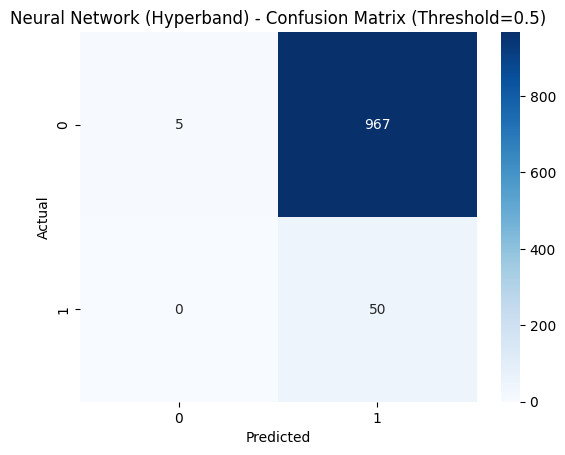


--- Comparison with Other Models ---
See above results for Random Forest, XGBoost, and Neural Network.
Compare Accuracy, Precision, Recall, F1 Score, and the Confusion Matrices.
Recall is particularly important for identifying stroke cases (minimizing False Negatives).
The Neural Network was tuned to maximize validation Recall during Hyperband search.


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(data_after_preprocessing['modified_balanced_training_features'].shape[1],)))

    # Hyperparameter tuning for number of dense layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                                     activation='relu'))
        # Optional: add dropout for regularization
        # model.add(keras.layers.Dropout(hp.Float('dropout_' + str(i), 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the optimizer and learning rate
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp.Float('adam_learning_rate', 1e-4, 1e-2, sampling='log'))
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp.Float('rmsprop_learning_rate', 1e-4, 1e-2, sampling='log'))
    elif hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp.Float('sgd_learning_rate', 1e-4, 1e-2, sampling='log'))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Using F1Score metric
    return model

print("\n--- Neural Network with Hyperband Tuning ---")

# Prepare data for Keras Tuner
X_train_smote = data_after_preprocessing['modified_balanced_training_features']
y_train_smote = data_after_preprocessing['modified_balanced_lables']
X_test = data_after_preprocessing['original_test_features']
y_test = data_after_preprocessing['labels_test']

# Handle potential column mismatch due to one-hot encoding on test set (already done, but re-aligning with SMOTE'd data is robust)
# Ensure compatible columns between training and test sets after all preprocessing
common_cols = list(set(X_train_smote.columns) & set(X_test.columns))
X_train_smote = X_train_smote[common_cols]
X_test = X_test[common_cols]

# The target variable y_test needs to be in the correct format if SMOTE changed it, but it's already 0/1 ints which is fine for binary_crossentropy
# y_train_smote and y_test are pandas Series/arrays of 0s and 1s

# Set up the Hyperband tuner
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_recall", direction="max"), # Optimize for Recall, important for minority class
                     max_epochs=50, # Maximum number of epochs to train a model
                     factor=3, # Factor by which to reduce the number of epochs and number of models
                     directory='hyperband_dir', # Directory to save the search results
                     project_name='stroke_prediction_nn')

# Define early stopping callback for tuning phase
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
# Using a validation split from the SMOTE'd training data for tuning
print("\nSearching for best hyperparameters...")
tuner.search(X_train_smote, y_train_smote, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nOptimal number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Optimal units in layer {i}: {best_hps.get('units_' + str(i))}")
print(f"Optimal optimizer: {best_hps.get('optimizer')}")
if best_hps.get('optimizer') == 'adam':
    print(f"Optimal Adam learning rate: {best_hps.get('adam_learning_rate')}")
elif best_hps.get('optimizer') == 'rmsprop':
     print(f"Optimal RMSprop learning rate: {best_hps.get('rmsprop_learning_rate')}")
elif best_hps.get('optimizer') == 'sgd':
     print(f"Optimal SGD learning rate: {best_hps.get('sgd_learning_rate')}")


# Build the final model with the optimal hyperparameters and train it on the entire SMOTE'd training data
print("\nBuilding and training final model with optimal hyperparameters...")
nn_model = tuner.hypermodel.build(best_hps)

# Define early stopping callback for final training
final_stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # Increased patience for final training

# Train the model
# It's good practice to use a validation set during training, even for the final model, to monitor overfitting
# Using the original test set as a pseudo-validation set here for simplicity with the given data structure,
# although ideally, one would split the SMOTE'd training data again for this.
history = nn_model.fit(X_train_smote, y_train_smote, epochs=100, validation_data=(X_test, y_test), callbacks=[final_stop_early]) # Train on full SMOTE, validate on original test

# Evaluate the final Neural Network model
print("\n--- Evaluation of Neural Network (Hyperband) ---")

# Need to adapt evaluate_model to work with Keras models
# Keras predict returns probabilities for sigmoid, need to threshold
def evaluate_nn_model(model, X_test, y_test, model_name, threshold=0.5):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int) # Apply threshold

    print(f"--- {model_name} (Threshold = {threshold}) ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall :", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Threshold={threshold})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the Neural Network with the standard threshold (0.5)
evaluate_nn_model(nn_model, X_test, y_test, "Neural Network (Hyperband)", threshold=0.5)

# You could also evaluate with a threshold optimized for recall if desired, similar to the evaluate_model_with_threshold function used for RF/XGB,
# but the prompt only asks to compare using the existing functions, and the primary evaluate_model (used for RF/XGB first) doesn't use thresholding.
# The confusion matrix drawing is included in the adapted evaluate_nn_model.

# Comparison Summary:
print("\n--- Comparison with Other Models ---")
print("See above results for Random Forest, XGBoost, and Neural Network.")
print("Compare Accuracy, Precision, Recall, F1 Score, and the Confusion Matrices.")
print("Recall is particularly important for identifying stroke cases (minimizing False Negatives).")
print("The Neural Network was tuned to maximize validation Recall during Hyperband search.")

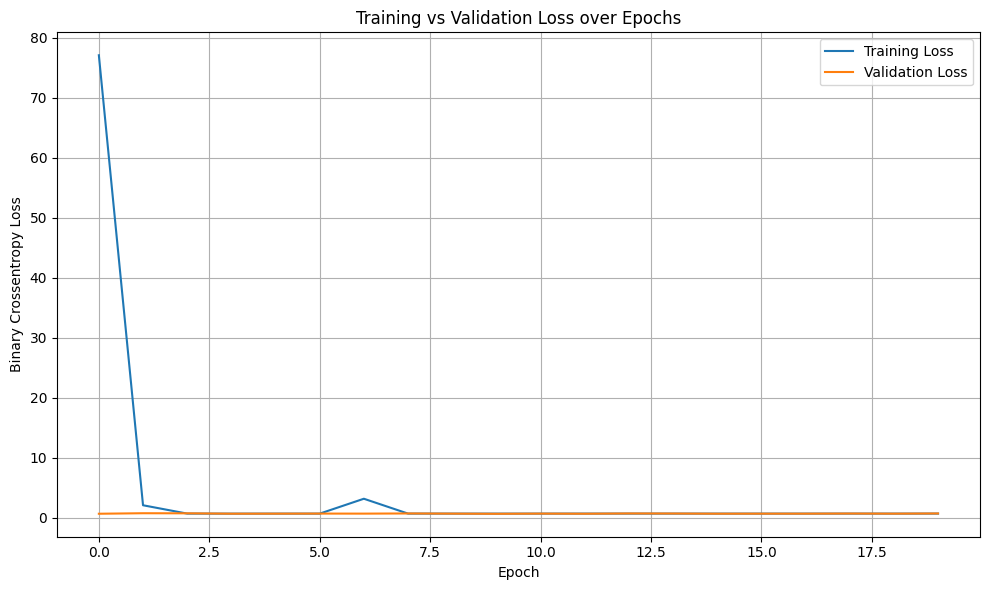

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Report Examples Where Model Was Wrong ---
import pandas as pd

# Get predicted probabilities and convert to binary (0 or 1) using threshold
y_pred_prob = nn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Convert to DataFrame for easier analysis
errors_df = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test.reset_index(drop=True),  # Ensure index matches
    'Probability': y_pred_prob.flatten()
})

# Find mismatches (wrong predictions)
mismatches = errors_df[errors_df['Predicted'] != errors_df['Actual']]

print("\n--- Sample Model Mistakes ---")

# Show a few false positives (predicted stroke when there was none)
false_positives = mismatches[(mismatches['Predicted'] == 1) & (mismatches['Actual'] == 0)]
print("\nFalse Positives (Predicted Stroke, Actually No Stroke):")
print(false_positives.head(5))

# Show a few false negatives (missed strokes)
false_negatives = mismatches[(mismatches['Predicted'] == 0) & (mismatches['Actual'] == 1)]
print("\nFalse Negatives (Missed Stroke Cases):")
print(false_negatives.head(5))

mistake_details = pd.concat([X_test.reset_index(drop=True), mismatches.reset_index(drop=True)], axis=1)
print(mistake_details.head())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Sample Model Mistakes ---

False Positives (Predicted Stroke, Actually No Stroke):
   Predicted  Actual  Probability
0          1       0      0.51386
1          1       0      0.51386
2          1       0      0.51386
3          1       0      0.51386
4          1       0      0.51386

False Negatives (Missed Stroke Cases):
Empty DataFrame
Columns: [Predicted, Actual, Probability]
Index: []
   heart_disease     id  smoking_status_smokes  Residence_type  work_type_Never_worked  smoking_status_never smoked  gender_Other  gender_Male  work_type_Self-employed  avg_glucose_level  work_type_Private  ever_married  hypertension   age   bmi  smoking_status_formerly smoked  work_type_children  Predicted  Actual  Probability
0              0  24202                  False               0                   False                         True         False         True                    False              78.23               True             1            